In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [59]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tskit as tsk

from bgspy.genome import Genome
from bgspy.utils import bin_chrom
from bgspy.data import GenomeData, pi_from_pairwise_summaries, trimmed_bins
from bgspy.sim_utils import mutate_simulated_tree
from bgspy.likelihood import FreeMutationModel
#from bgspy.sim_utils

In [4]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
#g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
#g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [9]:
file = '../data/chrombgs_chr10_thresh0_N1000_mu3.16e-09_sh0.0316_chr10_seed1519291738_rep1_treeseq.tree'
ts = tsk.load(file)

In [37]:
gd = GenomeData(g)
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [39]:
gd.load_counts_from_ts(mutate_simulated_tree(ts, rate=1e-7), chrom='chr10')

In [40]:
winsize = 1_000_000

bins, pi = gd.bin_pi(winsize)
bins2, Y = gd.bin_reduce(winsize, merge=True)
trim_bins, trim_Y, trim_idx = trimmed_bins(Y, bins, (0.0, 0.99))

(array([1192.40567668, 1589.87423557,  397.46855889, 1987.34279446,
        3179.74847114, 2384.81135335, 2384.81135335, 4769.62270671,
        6756.96550117, 5167.0912656 , 6359.49694228, 4769.62270671,
        3974.68558892, 2384.81135335,  794.93711778, 1192.40567668,
        1192.40567668,  794.93711778,  397.46855889,  397.46855889]),
 array([0.00018833, 0.00020753, 0.00022674, 0.00024594, 0.00026515,
        0.00028436, 0.00030356, 0.00032277, 0.00034197, 0.00036118,
        0.00038038, 0.00039959, 0.00041879, 0.000438  , 0.00045721,
        0.00047641, 0.00049562, 0.00051482, 0.00053403, 0.00055323,
        0.00057244]),
 <BarContainer object of 20 artists>)

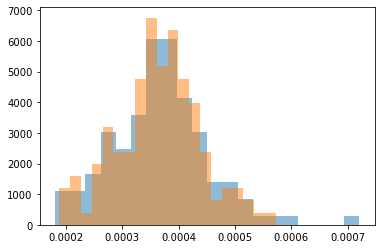

In [44]:
plt.hist(pi['chr10'].stat, 20, density=True, alpha=0.5)
plt.hist(pi_from_pairwise_summaries(trim_Y), 20, density=True, alpha=0.5)

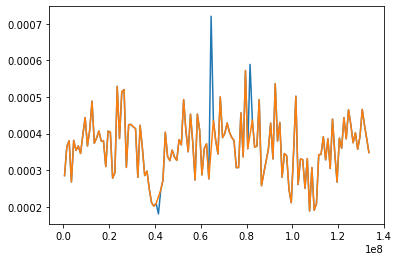

In [45]:
plt.plot(*pi['chr10'].pairs)

midpoints = [(s+e)/2 for c, s, e in trim_bins]
plt.plot(midpoints, pi_from_pairwise_summaries(trim_Y))

In [56]:
list(map(np.array, zip(*dat['bins'].flat)))

[array(['chr1', 'chr1', 'chr1', ..., 'chrX', 'chrX', 'chrX'], dtype='<U5'),
 array([        0,   1000000,   2000000, ..., 154000000, 155000000,
        156000000], dtype=uint32),
 array([  1000000,   2000000,   3000000, ..., 155000000, 156000000,
        156040895], dtype=uint32)]

In [58]:
dat = pickle.load(open('../tests/likelihood_test_data.pkl', 'rb'))
B, Bp, Y, w, t = dat['B'], dat['Bp'], dat['Y'], dat['w'], dat['t']
chroms, start, end = list(map(np.array, zip(*dat['bins'].flat)))
midpoint = (start+end)/2

nx, nw, nt, nf = B.shape
nparams = nt * nf + 2

In [60]:
np.random.seed(0)
lik_nml = FreeMutationModel(w, t, Bp, Y=Y)
lik_nml.fit(starts=70, ncores=70, algo='NELDERMEAD')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:41<00:00,  1.67it/s]


In [82]:
lik_nml

MLE (interpolated w): 6 x 5 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 1025585715416.9175
π0 = 0.0018435933298441868
W = 
---------  -----------  ---------
0.0041649  0.626767     0.794283
0.0793443  0.00135782   0.0772203
0.0306154  0.000747355  0.0306913
0.0706896  0.0295465    0.0735142
0.815186   0.341581     0.0242914
---------  -----------  ---------
μ = 
-----------  ----------  -----------
3.66327e-09  1.5178e-08  3.50294e-09
-----------  ----------  -----------

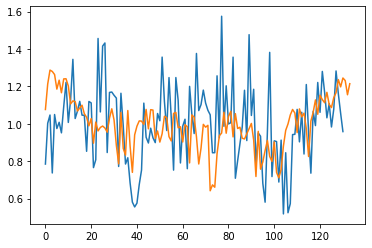

In [85]:
def ratio(x):
    return x/np.nanmean(x)


#plt.plot(ratio(pi['chr10'].pairs[1]))

#midpoints = [(s+e)/2 for c, s, e in trim_bins]
plt.plot(ratio(pi_from_pairwise_summaries(trim_Y)))

idx = chroms == 'chr10'
plt.plot(ratio(lik_nml.predict()[idx]))

In [69]:
lik_nml.predict()[trim_idx]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3044 but corresponding boolean dimension is 134